In [60]:
import numpy as np 
import pandas as pd 

from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Input
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import re

In [61]:
dataTrain = pd.read_csv('./data/twitter_train.csv')
dataTrain.columns = ["tweet id", "entity", "sentiment", "content"]
dataTrain.drop(["tweet id", "entity"],inplace=True, axis=1)

dataTrain.head()

,sentiment,content
0,Positive,I am coming to the borders and I will kill you...
1,Positive,im getting on borderlands and i will kill you ...
2,Positive,im coming on borderlands and i will murder you...
3,Positive,im getting on borderlands 2 and i will murder ...
4,Positive,im getting into borderlands and i can murder y...


In [62]:
Le = LabelEncoder()
dataTrain["encodedSentiment"] = Le.fit_transform(dataTrain["sentiment"])
dataTrain.head()

,sentiment,content,encodedSentiment
0,Positive,I am coming to the borders and I will kill you...,3
1,Positive,im getting on borderlands and i will kill you ...,3
2,Positive,im coming on borderlands and i will murder you...,3
3,Positive,im getting on borderlands 2 and i will murder ...,3
4,Positive,im getting into borderlands and i can murder y...,3


In [63]:
dataTrain.isnull().sum()

sentiment             0
content             686
encodedSentiment      0
dtype: int64

In [64]:
dataTrain.dropna(inplace=True)

In [65]:
dataTrain.isnull().sum()

sentiment           0
content             0
encodedSentiment    0
dtype: int64

In [66]:
Le.classes_

array(['Irrelevant', 'Negative', 'Neutral', 'Positive'], dtype=object)

In [67]:
dataTrain["sentiment"].value_counts()

sentiment
Negative      22358
Positive      20654
Neutral       18108
Irrelevant    12875
Name: count, dtype: int64

In [68]:
dataTrain = dataTrain[dataTrain.sentiment != "Irrelevant"]

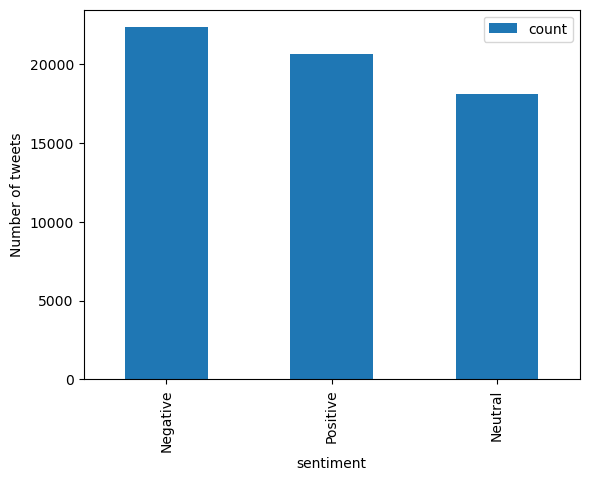

In [69]:
distr = dataTrain["sentiment"].value_counts()
plot = distr.plot(kind="bar")
plot.set_ylabel('Number of tweets')
plot.legend()
plt.show()

In [70]:
dataTrain['content'] = dataTrain['content'].apply(lambda x: x.lower())
dataTrain['content'] = dataTrain['content'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))

print(dataTrain[ dataTrain['sentiment'] == 'Positive'].size)
print(dataTrain[ dataTrain['sentiment'] == 'Neutral'].size)
print(dataTrain[ dataTrain['sentiment'] == 'Negative'].size)

for idx,row in dataTrain.iterrows():
    row.iloc[0] = row.iloc[0].replace('rt',' ')
    
maxFeatures = 2000
tokenizer = Tokenizer(num_words=maxFeatures, split=' ')
tokenizer.fit_on_texts(dataTrain['content'].values)
X = tokenizer.texts_to_sequences(dataTrain['content'].values)
X = pad_sequences(X)

61962
54324
67074


In [79]:
embed_dim = 128
lstm_out = 196

model = Sequential()
model.add(Input(shape=(X.shape[1],)))
model.add(Embedding(2000, embed_dim))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

c:\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_9 (Embedding)         │ (None, 166, 128)       │       256,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_4             │ (None, 166, 128)       │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 196)            │       254,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 2)              │           394 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 511,194 (1.95 MB)

 Trainable params: 511,194 (1.95 MB)

 Non-trainable params: 0 (0.00 B)

None
